# Training Materials: ALOS-2 Data Preprocessing and Calibration

This notebook provides a practical guide to preprocessing ALOS-2 data, focusing on speckle noise reduction and radiometric calibration.

## Module 1: Introduction to ALOS-2 Data and Preprocessing

### 1.1 ALOS-2
- ALOS-2 (Advanced Land Observing Satellite-2) is a Japanese Earth observation satellite equipped with an L-band synthetic aperture radar (SAR).  It provides high-resolution imagery regardless of weather conditions, making it valuable for various applications.
- Preprocessing is crucial for enhancing the quality and interpretability of ALOS-2 data by mitigating inherent noise and ensuring accurate measurements.

### 1.2 Common Preprocessing Steps:
- **Speckle filtering:** Speckle noise, a granular interference pattern, is inherent in SAR imagery. Speckle filtering reduces this noise, improving image clarity.
- **Radiometric calibration:** Calibration converts digital pixel values to physical units (e.g., backscatter), enabling quantitative analysis.

## Module 2: Working with ALOS-2 Data in Python

### 2.1 Setting up the Environment
- Installing Necessary Libraries

In [1]:
!pip install rasterio numpy geopandas matplotlib scipy scikit-image

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 1.6 MB/s eta 0:00:0000:0100:01
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl (24.1 MB)
Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_

### 2.2 Data Downloading
- Downloading ALOS-2 data from OwnCloud (or other sources).

**NOTE:** 
- ALOS-2 data can be obtained from the Japan Aerospace Exploration Agency (JAXA).
- Ensure the data is in GeoTIFF format for compatibility with the provided code.

In [2]:
!curl --output 2-Yamba.zip "https://owncloud.glodal-inc.net/owncloud/index.php/s/fORunC9aDo38G5s/download"

import shutil, os
shutil.unpack_archive("2-Yamba.zip", ".")
os.chdir('Yamba')
os.listdir()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  194M  100  194M    0     0  2672k      0  0:01:14  0:01:14 --:--:-- 2795k


['IMG-HH-ALOS2281962880-190813-UBSR2.1GUD.tif',
 'IMG-HH-ALOS2290760720-191011-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2294382880-191105-UBSR2.1GUD.tif',
 'IMG-HH-ALOS2299040720-191206-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2308650720-200209-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2310942880-200225-UBSR2.1GUD.tif']

### 2.3 Data Preprocessing

In [2]:
import os
import numpy as np
import rasterio
from skimage import img_as_float
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
import math
import re

#### 2.3.1 Speckle Filtering and Radiometric Calibration

**I. Introduction to Speckle Filtering Techniques:**
- Various speckle filters exist, including Lee, Frost, and Refined Lee.  The Lee filter is a commonly used adaptive filter.

**II. ALOS-2 Calibration Formula:**
- `calibrated_image = (10 * np.log10(image**2)) - 83`
- This formula converts pixel values to decibels, representing radar backscatter. The constants are specific to ALOS-2.

**III. Implementing the Lee Filter and Applying Calibration:**

In [3]:
# Define a Lee filter function
def lee_filter(image, size):
    image = image.astype(np.float32)
    local_mean = uniform_filter(image, size=size)
    local_mean_sqr = uniform_filter(image**2, size=size)
    local_variance = local_mean_sqr - local_mean**2
    overall_variance = np.mean(local_variance)
    weight = local_variance / (local_variance + overall_variance)
    weight = np.clip(weight, 0, 1)
    filtered_image = local_mean + weight * (image - local_mean)
    return filtered_image

In [4]:
# Calibration function
def calibrate_image(image):
    image = img_as_float(image)
    calibrated_image = (10 * np.log10(image**2)) - 83
    return calibrated_image

In [5]:
# Define input folder and output folder
input_folder = "/home/jovyan/shared/Arissara/genAI/Yamba"
output_folder = "/home/jovyan/shared/Arissara/genAI/processed_images"
os.makedirs(output_folder, exist_ok=True)

In [6]:
# Process files
image_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
preprocessed_images = []

for file in image_files:
    input_path = os.path.join(input_folder, file)
    with rasterio.open(input_path) as src:
        if src.count >= 1:
            img = src.read(1)  # Read the first band
            profile = src.profile  # Copy metadata for saving
        else:
            raise ValueError(f"File {file} does not contain a valid band.")
    
    # Step 1: Apply speckle filter
    filtered_img = lee_filter(img, size=5)
    
    # Step 2: Convert to backscatter coefficients
    calibrated_img = calibrate_image(filtered_img)
    preprocessed_images.append(calibrated_img)
    
    # Step 3: Save processed image
    output_path = os.path.join(output_folder, f"processed_{file}")
    profile.update(dtype=rasterio.float32, count=1)  # Update metadata for the output file
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(calibrated_img.astype(np.float32), 1)

#### 2.3.2 Visualizing calibrated data.

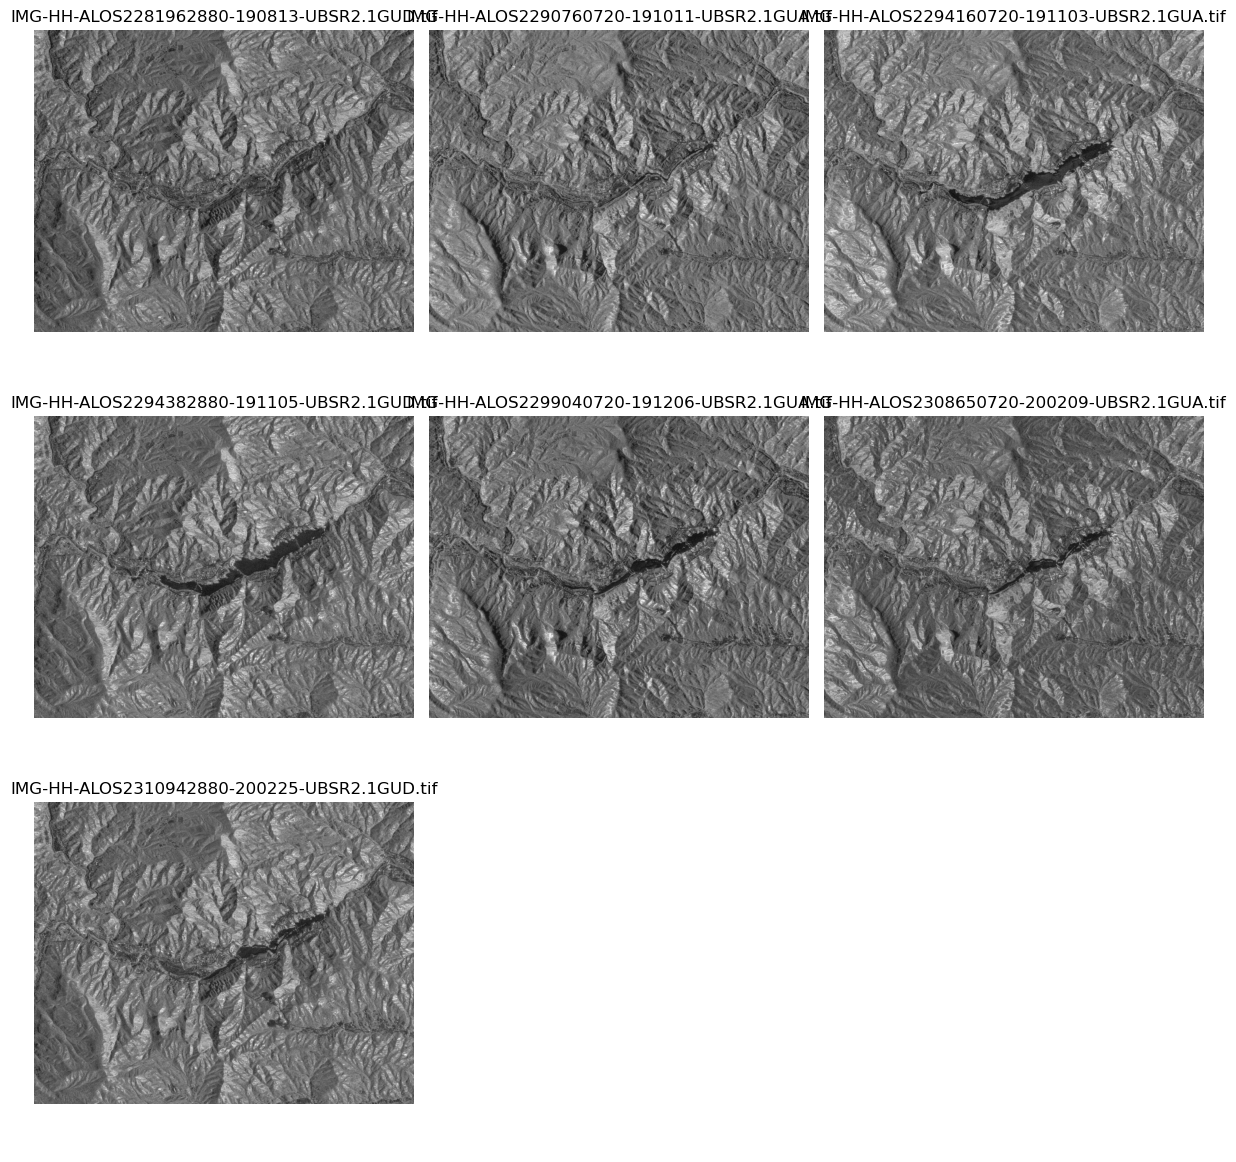

In [12]:
# Plot images
nrows = 3
ncols = math.ceil(len(preprocessed_images) / nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = axes.flatten()

for i, image in enumerate(preprocessed_images):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(image_files[i])  # Set title as the filename

for ax in axes[len(preprocessed_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()